<a href="https://colab.research.google.com/github/H-1000/HealthCare-Provider-Fraud-Detection-Project/blob/main/01_data_exploration_and_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration and Feature Engineering

## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
pd.set_option('display.max_columns', None)

beneficiary_df = pd.read_csv('/content/Train_Beneficiarydata-1542865627584.csv')
inpatient_df = pd.read_csv('/content/Train_Inpatientdata-1542865627584.csv')
outpatient_df = pd.read_csv('/content/Train_Outpatientdata-1542865627584.csv')
labels_df = pd.read_csv('/content/Train-1542865627584.csv')

## 3. Load Datasets

### 3.1 Data Quality & Completeness Check
Checking for missing values and duplicates.

In [ ]:
def check_data_quality(df, name):
    print(f"--- {name} ---")
    print(f"Shape: {df.shape}")
    print(f"Missing Values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")
    print(f"Duplicates: {df.duplicated().sum()}\n")

check_data_quality(beneficiary_df, "Beneficiary Data")
check_data_quality(inpatient_df, "Inpatient Data")
check_data_quality(outpatient_df, "Outpatient Data")
check_data_quality(labels_df, "Labels Data")

--- Beneficiary Data ---
Shape: (138556, 25)
Missing Values:
DOD    137135
dtype: int64
Duplicates: 0

--- Inpatient Data ---
Shape: (40474, 30)
Missing Values:
AttendingPhysician       112
OperatingPhysician     16644
OtherPhysician         35784
DeductibleAmtPaid        899
ClmDiagnosisCode_2       226
ClmDiagnosisCode_3       676
ClmDiagnosisCode_4      1534
ClmDiagnosisCode_5      2894
ClmDiagnosisCode_6      4838
ClmDiagnosisCode_7      7258
ClmDiagnosisCode_8      9942
ClmDiagnosisCode_9     13497
ClmDiagnosisCode_10    36547
ClmProcedureCode_1     17326
ClmProcedureCode_2     35020
ClmProcedureCode_3     39509
ClmProcedureCode_4     40358
ClmProcedureCode_5     40465
ClmProcedureCode_6     40474
dtype: int64
Duplicates: 0

--- Outpatient Data ---
Shape: (119605, 27)
Missing Values:
AttendingPhysician          315
OperatingPhysician        98725
OtherPhysician            74657
ClmDiagnosisCode_1         2410
ClmDiagnosisCode_2        45307
ClmDiagnosisCode_3        72761
ClmDiagn

## 4. Preprocessing & Merging

We need to aggregate claim-level data to provider-level data since the target variable (Fraud) is at the provider level.

### 4.1 Combine Inpatient and Outpatient Data
Both datasets have similar structures (claims). We'll add a flag to distinguish them.

In [ ]:
inpatient_df['ClaimType'] = 'Inpatient'
outpatient_df['ClaimType'] = 'Outpatient'

claims_df = pd.concat([inpatient_df, outpatient_df], axis=0, ignore_index=True)
print("Total Claims:", claims_df.shape)

Total Claims: (160079, 31)


### 4.2 Merge with Beneficiary Data
Join on `BeneID` to add patient demographics and chronic conditions to each claim.

In [ ]:
full_df = pd.merge(claims_df, beneficiary_df, on='BeneID', how='left')
print("Full Data Shape:", full_df.shape)

Full Data Shape: (160079, 55)


### 4.3 Feature Engineering (Provider Level)
We will aggregate data by `Provider` to create features for our model.

Key features to create:
- **Claim Counts**: Total claims, Inpatient/Outpatient counts.
- **Financials**: Total/Avg Reimbursed Amount, Deductibles.
- **Network**: Unique Beneficiaries, Unique Attending Physicians.
- **Patient Profile**: Avg Age, Chronic Condition Counts.
- **Diagnosis/Procedure Counts**: Unique diagnosis codes used.
- **State**: Most common state for the provider's patients.

In [ ]:
# Helper to calculate age
full_df['DOB'] = pd.to_datetime(full_df['DOB'], format='%Y-%m-%d')
full_df['ClaimStartDt'] = pd.to_datetime(full_df['ClaimStartDt'], format='%Y-%m-%d')
full_df['Age'] = (full_df['ClaimStartDt'] - full_df['DOB']).dt.days // 365

# Encode Chronic Conditions (1=Yes, 2=No) -> Change to 1=Yes, 0=No
chronic_cols = [col for col in full_df.columns if 'ChronicCond' in col]
for col in chronic_cols:
    full_df[col] = full_df[col].replace(2, 0)

# Aggregation
provider_df = full_df.groupby('Provider').agg(
    TotalClaims=('ClaimID', 'count'),
    TotalInpatientClaims=('ClaimType', lambda x: (x == 'Inpatient').sum()),
    TotalOutpatientClaims=('ClaimType', lambda x: (x == 'Outpatient').sum()),
    TotalReimbursed=('InscClaimAmtReimbursed', 'sum'),
    AvgReimbursed=('InscClaimAmtReimbursed', 'mean'),
    TotalDeductible=('DeductibleAmtPaid', 'sum'),
    AvgDeductible=('DeductibleAmtPaid', 'mean'),
    UniqueBeneficiaries=('BeneID', 'nunique'),
    UniqueAttendingPhysicians=('AttendingPhysician', 'nunique'),
    AvgPatientAge=('Age', 'mean'),
    AvgHospitalStay=('AdmissionDt', lambda x: x.notnull().sum()), # Proxy for stay count
    MostCommonState=('State', lambda x: x.mode()[0] if not x.mode().empty else -1),
    # Sum of chronic conditions across all claims
    **{f'Sum_{col}': (col, 'sum') for col in chronic_cols}
).reset_index()

print("Provider Data Shape:", provider_df.shape)

Provider Data Shape: (4956, 24)


### 4.4 Merge with Labels

In [ ]:
final_df = pd.merge(provider_df, labels_df, on='Provider', how='left')
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
print("Final Data Shape:", final_df.shape)
final_df.head()

Final Data Shape: (4956, 25)


,Provider,TotalClaims,TotalInpatientClaims,TotalOutpatientClaims,TotalReimbursed,AvgReimbursed,TotalDeductible,AvgDeductible,UniqueBeneficiaries,UniqueAttendingPhysicians,AvgPatientAge,AvgHospitalStay,MostCommonState,Sum_ChronicCond_Alzheimer,Sum_ChronicCond_Heartfailure,Sum_ChronicCond_KidneyDisease,Sum_ChronicCond_Cancer,Sum_ChronicCond_ObstrPulmonary,Sum_ChronicCond_Depression,Sum_ChronicCond_Diabetes,Sum_ChronicCond_IschemicHeart,Sum_ChronicCond_Osteoporasis,Sum_ChronicCond_rheumatoidarthritis,Sum_ChronicCond_stroke,PotentialFraud
0,PRV51001,9,5,4,99120,11013.333333,5340.0,593.333333,9,8,75.777778,5,1,5,6,7,3,3,5,8,8,1,4,3,0
1,PRV51003,81,62,19,584890,7220.864198,66286.0,818.345679,71,19,69.716049,62,1,42,49,48,9,27,32,61,70,15,21,8,1
2,PRV51004,33,0,33,8230,249.393939,0.0,0.000000,32,16,72.212121,0,1,15,22,19,6,12,17,29,26,9,12,9,0
3,PRV51005,278,0,278,69880,251.366906,1210.0,4.352518,110,6,68.467626,0,1,114,182,130,50,62,89,215,228,87,96,22,1
4,PRV51007,17,3,14,20870,1227.647059,3204.0,188.470588,14,6,69.529412,3,1,9,10,2,4,5,6,10,13,2,8,5,0


## 5. Exploratory Data Analysis (EDA)

### 5.1 Class Imbalance

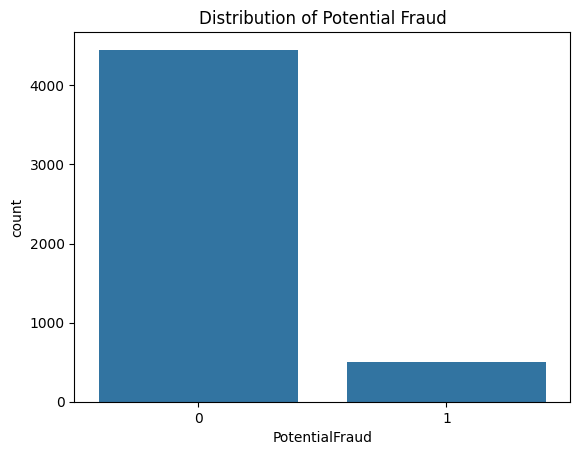

PotentialFraud
0    0.897902
1    0.102098
Name: proportion, dtype: float64


In [ ]:
sns.countplot(x='PotentialFraud', data=final_df)
plt.title('Distribution of Potential Fraud')
plt.show()

print(final_df['PotentialFraud'].value_counts(normalize=True))

### 5.2 Financials vs Fraud

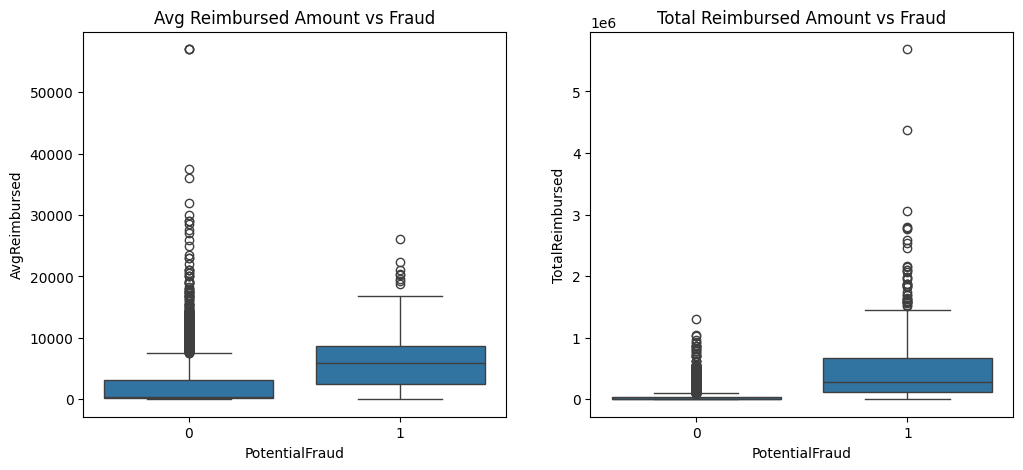

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='PotentialFraud', y='AvgReimbursed', data=final_df)
plt.title('Avg Reimbursed Amount vs Fraud')

plt.subplot(1, 2, 2)
sns.boxplot(x='PotentialFraud', y='TotalReimbursed', data=final_df)
plt.title('Total Reimbursed Amount vs Fraud')
plt.show()

### 5.3 Claims Volume vs Fraud

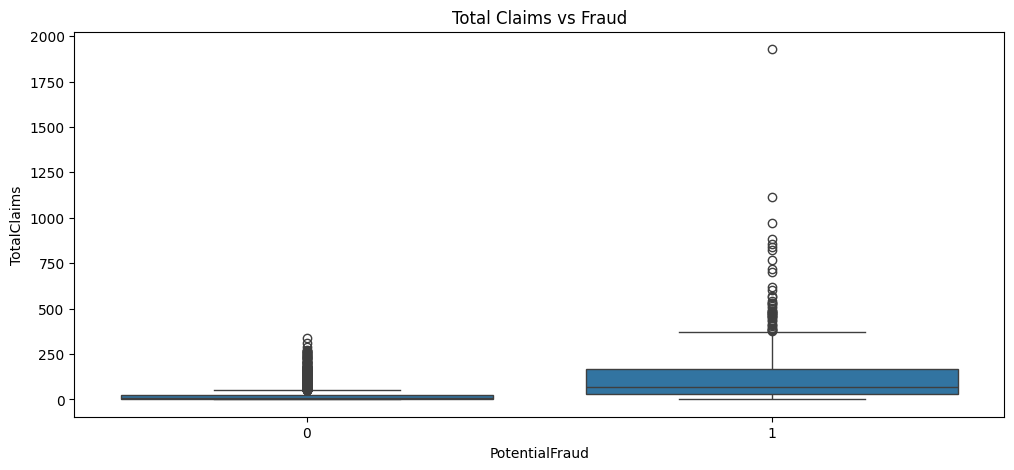

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='PotentialFraud', y='TotalClaims', data=final_df)
plt.title('Total Claims vs Fraud')
plt.show()

### 5.4 Correlation Heatmap

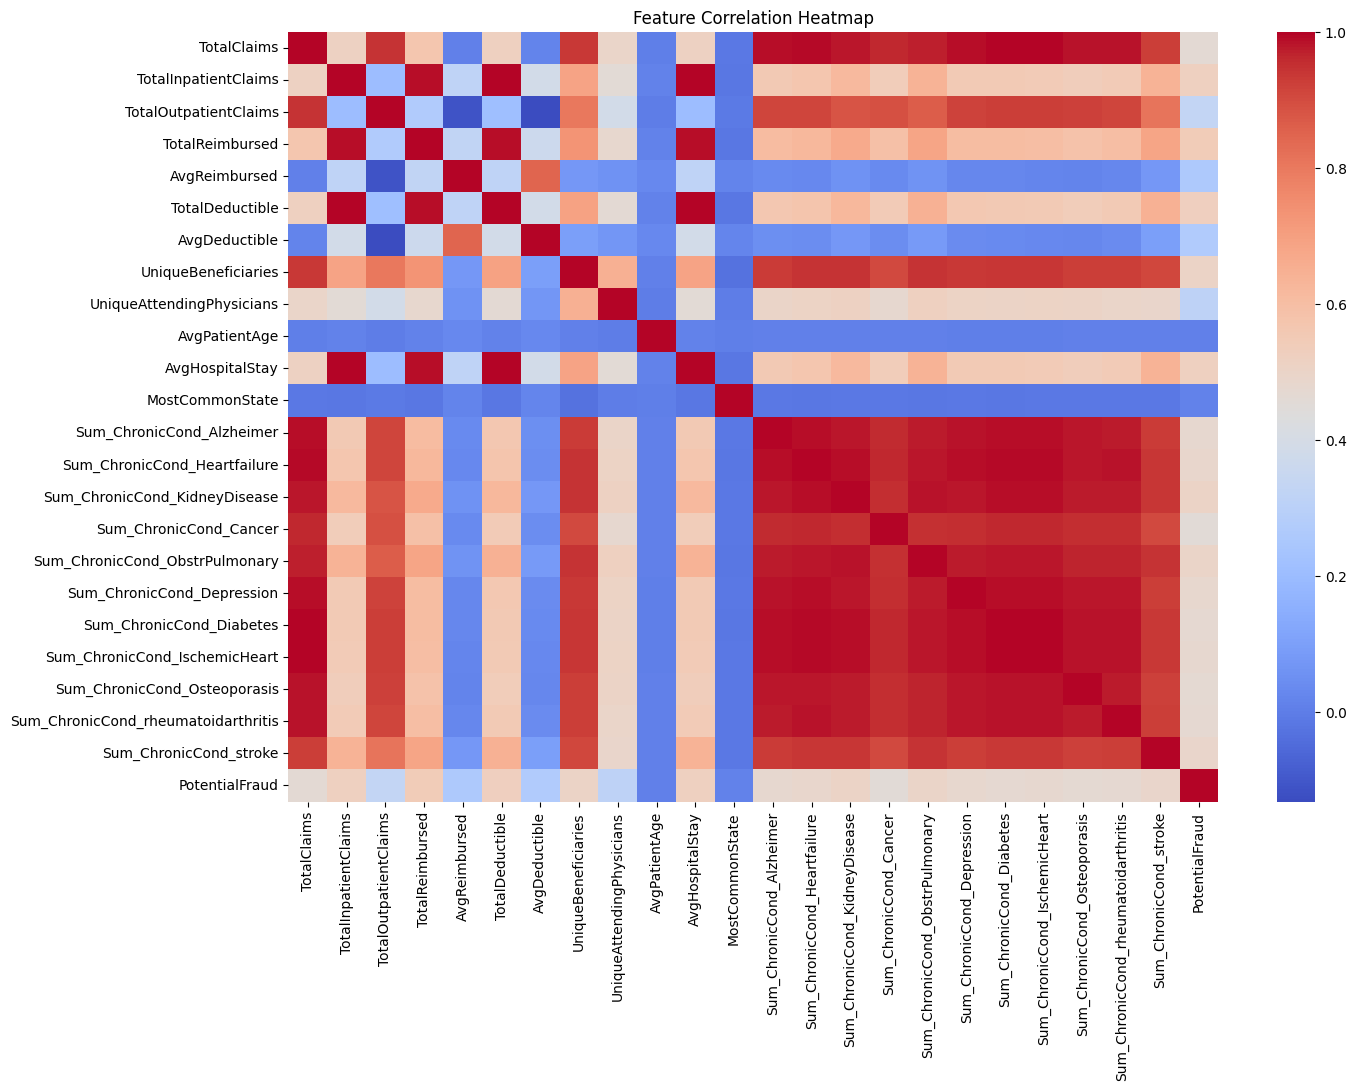

In [ ]:
plt.figure(figsize=(15, 10))
corr = final_df.drop(['Provider'], axis=1).corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

### 5.5 Geographic Analysis (State)

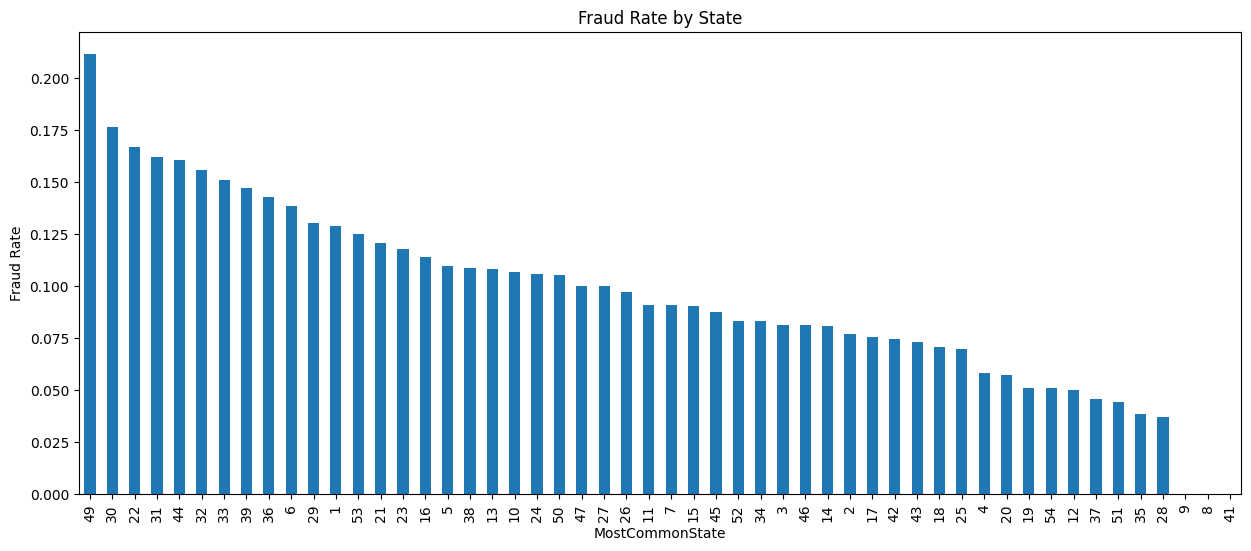

In [ ]:
plt.figure(figsize=(15, 6))
state_fraud = final_df.groupby('MostCommonState')['PotentialFraud'].mean().sort_values(ascending=False)
state_fraud.plot(kind='bar')
plt.title('Fraud Rate by State')
plt.ylabel('Fraud Rate')
plt.show()

## 6. Save Processed Data

In [ ]:
OUTPUT_DIR = '/content/output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

output_path = os.path.join(OUTPUT_DIR, 'processed_provider_data.csv')
final_df.to_csv(output_path, index=False)
print(f"Saved processed data to {output_path}")

Saved processed data to /content/output/processed_provider_data.csv
